In [1]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import joblib
from keras.models import load_model

from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import helper
from helper import preprocessor as pp

Using TensorFlow backend.


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12, 8

In [4]:
class_names = ['Hate','Offensive','Neutral']

In [5]:
# upload the dataset
data = pp.load_data('labeled_data.csv')
max_length = 140
data['clean_tweet'] = data.tweet.apply(lambda doc: pp.clean_doc(doc))
# drop any rows with null (after preprocessing)
data = data.dropna()
# print first 5 rows of the data set
data.head()

,labels,category,tweet,clean_tweet
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [6]:
# Upload saved model files
rf = joblib.load('Models/RF.pkl')
mlp = load_model('Models/MLP.h5')
cnn = load_model('Models/CNN.h5')
lstm = load_model('Models/LSTM.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [7]:
model_name = ['Random Forest','Multilayer Perceptrons','1D covnets','LSTM Networks']
model = [rf,mlp,cnn,lstm]

In [8]:
# Split test and train data 
X_train, y_train= data.clean_tweet[:20000],data.labels[:20000]
X_test, y_test = data.clean_tweet[20000:],data.labels[20000:]
y_test_onehot = to_categorical(y_test)

In [9]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train)
X_tf = vectorizer.transform(X_test)

In [10]:
# Initializer tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1
print('Total vocab size: {}'.format(vocab_size))
sequence_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequence_test, maxlen=26, padding='post')

Total vocab size: 18498


In [11]:
def performance_measure(clf,X, i):
    '''Input: model/ classifier
              X = Feature word vector
              i = parameter to differentail between DT and NN methods
        Output: hate# - count of True Positives (TP) for hate class
                offensive# - count of TP for offensive class
                neutral# - count of TP for neutral class
                avg_precision - Micro-average precision score (area under PR curve)
                f1_score - Micro-average f1-score
    '''
    y_pred_prob = clf.predict_proba(X)
    y_pred = clf.predict(X)
    if i:
        # for neural networks y needs to be exact prediction
        y_pred = np.argmax(y_pred_prob,axis=1)
    avp = average_precision_score(y_test_onehot, y_pred_prob,average='micro')
    fscore = f1_score(y_test.values,y_pred, average = 'micro')
    cm = confusion_matrix(y_test,y_pred)
    hate_cnt, off_cnt, neu_cnt = cm[0,0], cm[1,1], cm[2,2]
    return {'hate#':hate_cnt,'offensive#':off_cnt, 'neutral#':neu_cnt,'avg_precision':avp,'f1_score':fscore}

In [12]:
# Save the performance metrics
model_dict = {}
for i, val in enumerate(zip(model_name,model)):
    if i == 0:
        # TFIDF word vector for random forest
        X = X_tf
    else:
        # padded test layer
        X = padded_test
    model_dict[val[0]] = performance_measure(val[1],X,i)        

In [13]:
# convert model dict into a dataframe
modelname = []
perfmetrics = []
for m, pf in model_dict.items():
    modelname.append(m)
    perfmetrics.append(pd.DataFrame.from_dict(pf, orient='index'))
df = pd.concat(perfmetrics, keys=modelname)
# Move inner most index to column level
df = df.unstack(level=-1)[0]

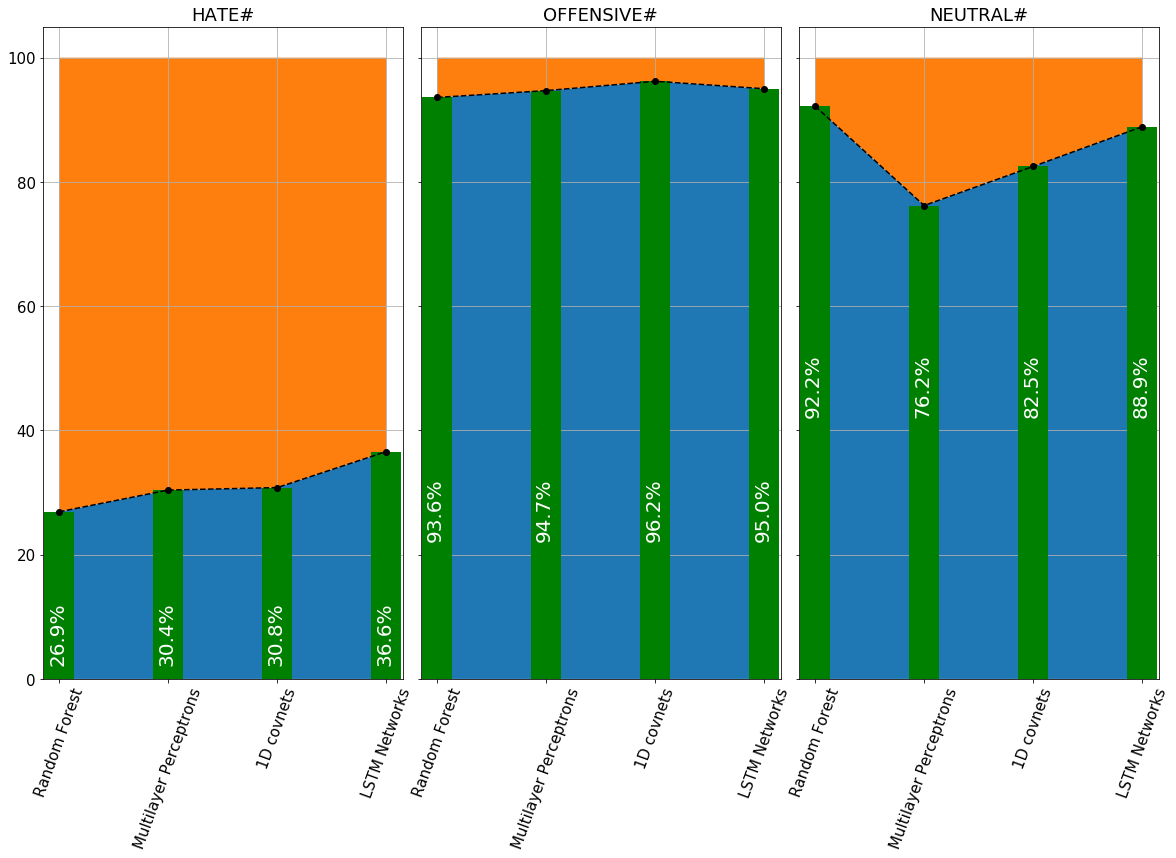

In [14]:
total = y_test.value_counts(ascending = True)
fig,axes = plt.subplots(1,3,figsize = (20,12),sharey = True)
for i in range(3):
    # Compute Relatie Ratio
    rat = np.round(df.iloc[:,i].values/total[i]*100,1)
    axes[i].stackplot(df.index,rat, 100-rat, alpha = 1)
    axes[i].plot(rat,'ko--')
    axes[i].vlines([0,1,2,3],[0,0,0,0],rat,linewidth = 30, color = 'green',alpha = 1)
    axes[i].set_title(df.columns[i].upper())
    axes[i].grid()
    for j in range(4):
        axes[i].text(j-0.1,10*(2*i+1),'{}%'.format(rat[j]),
                     rotation = 90,color = 'white',fontsize = '20')
    axes[i].tick_params(axis='x', labelrotation=70)
plt.subplots_adjust(wspace=0.05)
plt.show()

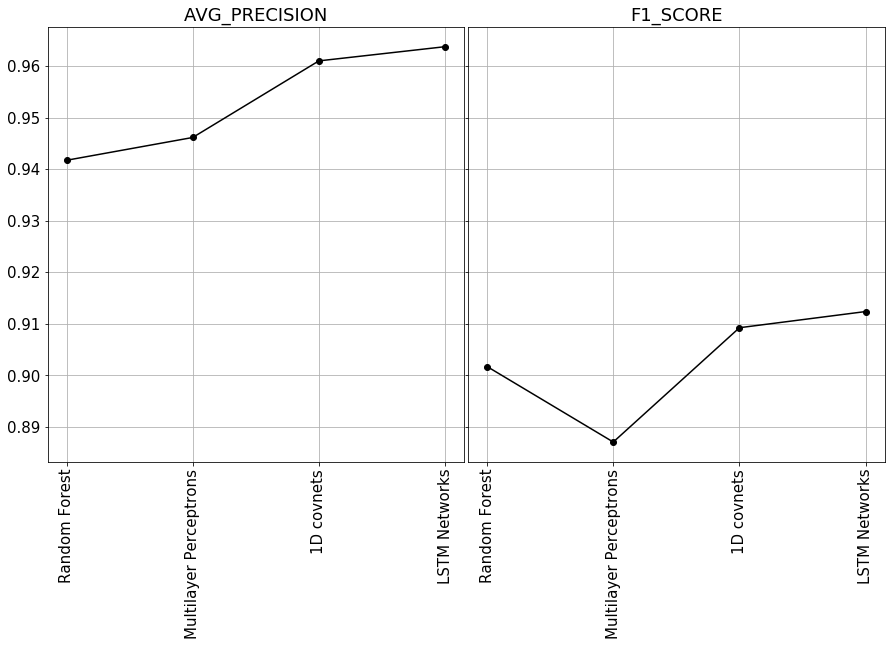

In [15]:
fig,axes = plt.subplots(1,2,figsize = (15,8),sharey = True)
for i in range(2):
    axes[i].plot(df.iloc[:,i+3], 'ko-')
    axes[i].grid()
    axes[i].tick_params(axis='x', labelrotation=90)  
    axes[i].set_title(df.columns[i+3].upper())
    
plt.subplots_adjust(wspace=0.01)
plt.show()